## Домашнее задание, вычисление аддитивного аттеншна

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [2]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

if torch.cuda.is_available():
    print('CUDA')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [54]:
#!tail rus_eng_small.txt

In [5]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt', encoding='utf-8') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [6]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...



Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['вы шутите !', 'you re joking !']


In [7]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru с заголовком "Домашнее задание по лекции seq2seq (Ваши Фамилия и Имя)"

In [9]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, nlayers, output_size, dropout_p=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size
        
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        # !!! Define layers needed for additive attention here
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.W_h = torch.rand(hidden_size, hidden_size)
        self.W_s = torch.rand(hidden_size, hidden_size)
        self.v_a = torch.rand(hidden_size ,1)
        self.Tanh = nn.Tanh()
        
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, x, hidden, encoder_outputs):
        """
        :param x: [T2,B] - входной тензор с предыдущими словами размерностью timestep на batch
        :param hidden [1, B, C] - состояние рнн слоя
        :param encoder_outputs [T1,B,C] - выходы всех шагов энкодера
        :return output: [T2,B,C], hidden - С=hidden_size, возвращается только последний hidden state
        """
        embedded = self.embedding(x) # [T2,B,C]
        embedded = self.dropout(embedded)
        embedded = embedded.transpose(0, 1) # [B,T2,C]
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]

        context, attn_weights = self.attention(encoder_outputs, embedded)
        
        output = torch.cat((embedded, context), dim=-1) # [[B,1,C];[B,1,C]] -> [B,1,C*2]
        output = self.attn_combine(output).transpose(0,1) # [B,1,C*2] * [C*2,C] = [B,1,C] -transpose-> [1,B,C]
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        logits = self.out(output)
        output = F.log_softmax(logits, dim=-1)
        
        return output, hidden, attn_weights
    
    def attention(self, encoder_outputs, h):        
        embedded_t = h.transpose(1, -1)
        
        emb_expand = torch.matmul(self.W_h, embedded_t).unsqueeze(-1).expand(-1,
                                                                             -1, -1, encoder_outputs.size(1)).transpose(2, 3)
        enc_expand = torch.matmul(self.W_s, encoder_outputs.transpose(1, 2)).unsqueeze(-1).expand(-1,
                                                                                                  -1, -1, embedded_t.size(2))

        res = torch.matmul(self.v_a.transpose(0, 1), self.Tanh(emb_expand + enc_expand).permute(0, 2,
                                                                        3, 1).unsqueeze(-1)).squeeze(-1).squeeze(-1)
        
        attn_weights = F.softmax(res, dim = -2)
        context = torch.bmm(attn_weights.transpose(1,-1), encoder_outputs)
        
        return context, attn_weights

In [10]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [11]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [12]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [13]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [15]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [16]:
n_iters=10000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [17]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words, dropout_p=0.1).to(device)

In [42]:
teacher_forcing_ratio = 1.
learning_rate=0.00005
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

### Не забудьте запустить тренировку в ячейке ниже, а затем и evaluation

Train
0m 16s (- 26m 41s) (100 1%) 0.3003
0m 31s (- 25m 26s) (200 2%) 0.2977
0m 46s (- 25m 4s) (300 3%) 0.2853
1m 1s (- 24m 31s) (400 4%) 0.3219
1m 17s (- 24m 24s) (500 5%) 0.2592
1m 32s (- 24m 2s) (600 6%) 0.2777
1m 48s (- 23m 56s) (700 7%) 0.2959
2m 3s (- 23m 41s) (800 8%) 0.3265
2m 19s (- 23m 34s) (900 9%) 0.3033
2m 36s (- 23m 27s) (1000 10%) 0.3059
2m 54s (- 23m 28s) (1100 11%) 0.2977
3m 11s (- 23m 22s) (1200 12%) 0.3467
3m 28s (- 23m 17s) (1300 13%) 0.2533
3m 47s (- 23m 15s) (1400 14%) 0.3104
4m 5s (- 23m 9s) (1500 15%) 0.3435
4m 22s (- 22m 58s) (1600 16%) 0.2688
4m 39s (- 22m 46s) (1700 17%) 0.2772
4m 57s (- 22m 33s) (1800 18%) 0.3330
5m 15s (- 22m 25s) (1900 19%) 0.2747
5m 33s (- 22m 12s) (2000 20%) 0.2798
5m 50s (- 21m 59s) (2100 21%) 0.2955
6m 9s (- 21m 48s) (2200 22%) 0.3385
6m 27s (- 21m 36s) (2300 23%) 0.3215
6m 45s (- 21m 24s) (2400 24%) 0.2504
7m 4s (- 21m 12s) (2500 25%) 0.2938
7m 24s (- 21m 5s) (2600 26%) 0.3801
7m 45s (- 20m 58s) (2700 27%) 0.2746
8m 3s (- 20m 43s) (280

<Figure size 432x288 with 0 Axes>

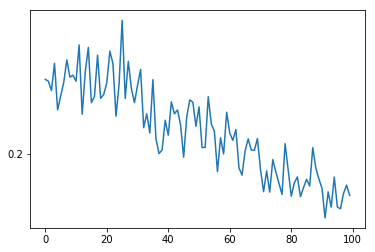

In [43]:
run_training(encoder, decoder, n_iters, print_every=100)

In [52]:
evaluate_randomly(encoder, decoder)

> я рад, что вы уговорили меня пойти .
= i m glad you talked me into going .
< i m glad you came today .

> я старше, чем твой брат .
= i am older than your brother .
< i m older than your brother .

> ты, вероятно, ошибаешься .
= you re probably mistaken .
< you re probably mistaken .

> меня пока не убедили .
= i m not convinced yet .
< i m not feeling nauseous .

> ты всего на три года старше меня .
= you re only three years older than me .
< you re only three years older than me .

> она лежит с простудой .
= she is down with a cold .
< she is poor with a student .

> я ваша, а вы мой .
= i am yours and you are mine .
< i am yours and you are .

> сейчас я занят написанием книги .
= i m now busy writing a book .
< i m busy doing homework now .

> у нас будет ребёнок .
= we re going to have a baby .
< we re a little early today .

> удивительно встретить тебя тут .
= i m surprised to find you here .
< you re out of danger .



input = я очень осторожна .
output = i m really careful .


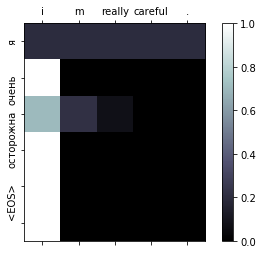

input = они всё ещё живут со своими родителями .
output = they are still living in love with .


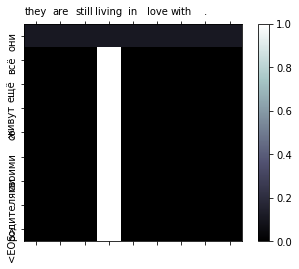

In [53]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")